In [6]:
%matplotlib inline

In [7]:
import numpy as np
import pandas as pd


actions = 1000
users = 10
items = 10
click_rate = 0.5

user = np.random.choice(range(users), size=actions)
item = np.random.choice(range(items), size=actions)
outcome = np.random.binomial(1, p=click_rate, size=actions)

df = pd.DataFrame({'user': user,
                   'item': item,
                   'outcome': outcome})
df.head()

,user,item,outcome
0,2,8,0
1,2,4,0
2,9,7,1
3,3,4,1
4,8,8,1


In [8]:
df.mean()

user       4.405
item       4.550
outcome    0.502
dtype: float64

In [9]:
def bootstrap(actions, statistic, replicates=1000):
    statistics = []
    for _ in range(replicates):
        replicate = actions.sample(len(actions), replace=True)
        statistics.append(statistic(replicate))
    return pd.Series(statistics)



In [10]:
statistic = lambda x: x.outcome.mean()
samples = bootstrap(df, statistic)

In [11]:
def bootstrap_poisson_weight(actions, replicates=1000):
    statistics = []
    for _ in range(replicates):
        actions['weight'] = np.random.poisson(1, size=len(actions))
        actions['weighted'] = actions['weight'] * actions['outcome']
        statistics.append(actions['weighted'].sum() / actions['weight'].sum())
    return pd.Series(statistics)



In [12]:
samples_poisson_weight = bootstrap_poisson_weight(df)

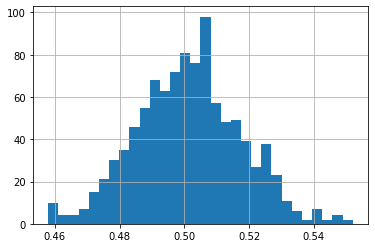

In [13]:
samples.hist(bins=30)

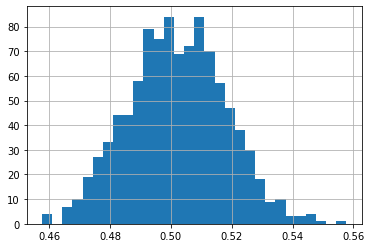

In [14]:
samples_poisson_weight.hist(bins=30)

In [15]:
samples.mean(), samples_poisson_weight.mean()

(0.50137, 0.5020589746990276)

In [16]:
samples.std(), samples_poisson_weight.std()

(0.016115545625600494, 0.015957483950009125)

## From our experiment before

In [17]:
import numpy as np
import pandas as pd

N = 1000
delta = 1.

y0 = np.random.normal(size=N)
y1 = np.random.normal(delta, size=N)

deltas = y1 - y0

df = pd.DataFrame({'$Y^{(D=1)}$': y1, 
                   '$Y^{(D=0)}$': y0, 
                   '$\delta$': deltas})

df['$D$'] = np.random.binomial(1, p=0.5, size=N)
df['$Y$'] = df['$D$'] * df['$Y^{(D=1)}$'] + \
            (1. - df['$D$']) * df['$Y^{(D=0)}$']



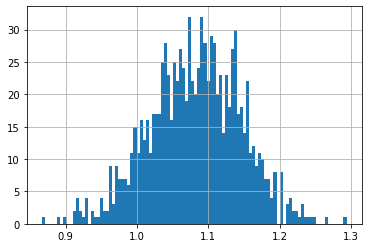

In [21]:
statistic = lambda x: x[x['$D$'] == 1]['$Y$'].mean() - x[x['$D$'] == 0]['$Y$'].mean()
samples = bootstrap(df, statistic)
samples.hist(bins=100)

In [22]:
samples.describe()

count    1000.000000
mean        1.081776
std         0.063777
min         0.867250
25%         1.038478
50%         1.083581
75%         1.128403
max         1.293691
dtype: float64

## Dependent Samples

In [44]:
def dependent_bootstrap(actions, units=[], replicates=1000):
    statistics = []
    for _ in range(replicates):
        if not units:
            actions['weight'] = np.random.poisson(1, size=len(actions))
        else:
            actions['weight'] = 1.
        for unit in units:
            distinct_units = actions[unit].unique()
            unit_df = pd.DataFrame({unit: distinct_units, 
                                   '{}_weight'.format(unit): np.random.poisson(1, size=len(distinct_units))})
            actions = actions.merge(unit_df, on=unit)
            actions['weight'] = actions['weight'] * actions['{}_weight'.format(unit)]
            del actions['{}_weight'.format(unit)]
        actions['weighted'] = actions['outcome'] * actions['weight']
        statistics.append(actions['weighted'].sum() / actions['weight'].sum())
    return pd.Series(statistics)


In [45]:
samples_poisson_dependent = dependent_bootstrap(df, units=['user', 'item'])

In [46]:
samples.mean(), samples_poisson_weight.mean(), samples_poisson_dependent.mean()

(0.504548, 0.5055518003621292, 0.5064482091931171)

In [47]:
samples.std(), samples_poisson_weight.std(), samples_poisson_dependent.std()

(0.01639776151133389, 0.016007665911896157, 0.028678818625400795)

In [29]:
import numpy as np
import pandas as pd


actions = 100
users = 10
items = 10

user = np.random.choice(range(users), size=actions)
item = np.random.choice(range(items), size=actions)
click_rate = (2 + user + item) / 22.


outcome = np.random.binomial(1, p=click_rate, size=actions)

df = pd.DataFrame({'user': user,
                   'item': item,
                   'outcome': outcome})
df.head()

,user,item,outcome
0,6,1,1
1,2,1,0
2,8,9,0
3,9,6,1
4,6,5,1


In [30]:
df.mean()

user       4.61
item       4.65
outcome    0.53
dtype: float64

In [31]:
samples_dependent_bootstrap = dependent_bootstrap(df, units=['user', 'item'])

statistic = lambda x: x.outcome.mean()
samples = bootstrap(df, statistic)

In [32]:
samples.mean(), samples_dependent_bootstrap.mean()

(0.53031, 0.5323762013516788)

In [33]:
samples.std(), samples_dependent_bootstrap.std()

(0.049661556260050595, 0.09359453503355453)